# Data set gộp từ 2 bộ victsd và vihsd

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/merged.csv")
null_counts = df.isnull().sum()
print("Null value summary:")
print(null_counts[null_counts > 0] if null_counts.any() else "No nulls found")
df.dropna(inplace=True)

Null value summary:
text    2
dtype: int64


Ratio:
origin
Dataset    0.193048
vihsd      0.209240
victsd     0.145064
dtype: float64


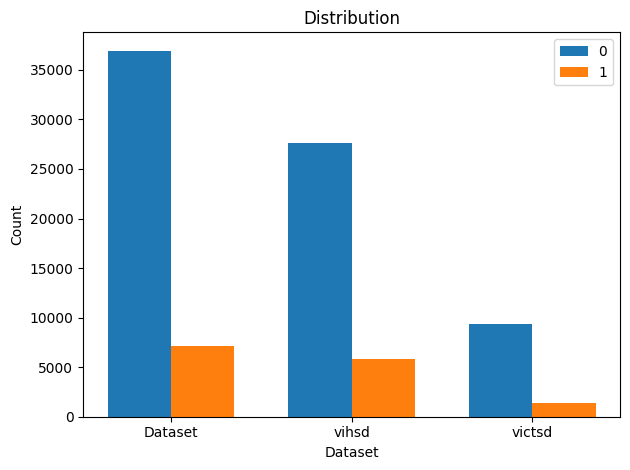

In [21]:
counts_df = df.groupby(["new_label", "origin"]).size().unstack(fill_value=0)
counts_df["Dataset"] = df.groupby("new_label").size()
counts_df = counts_df[["Dataset", "vihsd", "victsd"]]

groups = ["Dataset", "vihsd", "victsd"]
counts = [counts_df.loc[0, groups], counts_df.loc[1, groups]]

rate = counts[1] / counts[0]
print("Ratio:")
print(rate)

x = range(len(groups))
bar_width = 0.35

plt.bar(x, counts[0], width=bar_width, label="0")
plt.bar([i + bar_width for i in x], counts[1], width=bar_width, label="1")

plt.xlabel("Dataset")
plt.ylabel("Count")
plt.title("Distribution")
plt.xticks([i + bar_width / 2 for i in x], groups)
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from utils.preprocess import preprocess_text

print(torch.__version__)

# Cấu hình
MODEL_NAME = "vinai/phobert-base-v2"
MODEL_PATH = "models/best_phobert_fullset.pt"
BATCH_SIZE = 4
MAX_LEN = 256

# Thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model & tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)
model.eval()

# Dataset
class SentimentDataset(Dataset):
    def __init__(self, df):
        self.texts = [preprocess_text(t) for t in df['text']]
        self.labels = df['new_label'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Load test.csv
df = pd.read_csv("data/full/test.csv").dropna(subset=["text", "new_label"])
test_dataset = SentimentDataset(df)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Dự đoán
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

# In kết quả
print(classification_report(all_labels, all_preds, digits=4))

2.5.1+cu118


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ASUS\AppData\Local\Temp\ipykernel_50332\3199790347.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via thi

              precision    recall  f1-score   support

           0     0.8845    0.9450    0.9138      7388
           1     0.5587    0.3604    0.4382      1426

    accuracy                         0.8505      8814
   macro avg     0.7216    0.6527    0.6760      8814
weighted avg     0.8318    0.8505    0.8368      8814



# Cân bằng lại dữ liệu

## Oversampling

Ratio:
origin
Dataset       0.507333
vihsd         0.428148
victsd        0.300444
gen-vihsd          inf
gen-victsd         inf
dtype: float64


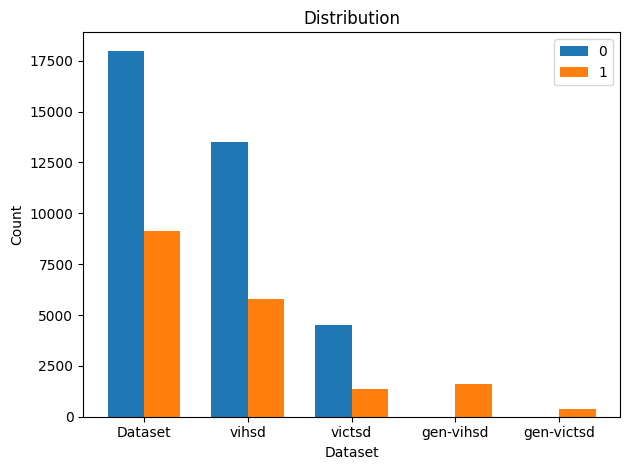

In [23]:
df = pd.read_csv("data/balanced.csv")

counts_df = df.groupby(["new_label", "origin"]).size().unstack(fill_value=0)
counts_df["Dataset"] = df.groupby("new_label").size()
counts_df = counts_df[["Dataset", "vihsd", "victsd", "gen-vihsd", "gen-victsd"]]

groups = ["Dataset", "vihsd", "victsd", "gen-vihsd", "gen-victsd"]
counts = [counts_df.loc[0, groups], counts_df.loc[1, groups]]

rate = counts[1] / counts[0]
print("Ratio:")
print(rate)

x = range(len(groups))
bar_width = 0.35

plt.bar(x, counts[0], width=bar_width, label="0")
plt.bar([i + bar_width for i in x], counts[1], width=bar_width, label="1")

plt.xlabel("Dataset")
plt.ylabel("Count")
plt.title("Distribution")
plt.xticks([i + bar_width / 2 for i in x], groups)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from utils.preprocess import preprocess_text

print(torch.__version__)

# Cấu hình
MODEL_NAME = "vinai/phobert-base-v2"
MODEL_PATH = "models/best_phobert_oversampling.pt"
BATCH_SIZE = 4
MAX_LEN = 256

# Thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model & tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)
model.eval()

# Dataset
class SentimentDataset(Dataset):
    def __init__(self, df):
        self.texts = [preprocess_text(t) for t in df['text']]
        self.labels = df['new_label'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Load test.csv
df = pd.read_csv("data/oversampling/test.csv").dropna(subset=["text", "new_label"])
test_dataset = SentimentDataset(df)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Dự đoán
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

# In kết quả
print(classification_report(all_labels, all_preds, digits=4))

2.5.1+cu118


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ASUS\AppData\Local\Temp\ipykernel_50332\791998596.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this

              precision    recall  f1-score   support

           0     0.8721    0.8883    0.8801      3600
           1     0.7716    0.7433    0.7572      1827

    accuracy                         0.8395      5427
   macro avg     0.8218    0.8158    0.8187      5427
weighted avg     0.8383    0.8395    0.8387      5427



=> cải thiện đáng kể f1

In [25]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Để hiển thị tiến độ trong quá trình huấn luyện
import joblib  # Để lưu và tải mô hình

# Đọc dữ liệu
train_df = pd.read_csv("data/oversampling/train.csv")
val_df = pd.read_csv("data/oversampling/val.csv")
test_df = pd.read_csv("data/oversampling/test.csv")

# Áp dụng tiền xử lý cho dữ liệu và theo dõi tiến độ
tqdm.pandas(desc="Applying preprocess_text to Train data")
train_df['text'] = train_df['text'].progress_apply(lambda x: preprocess_text(x))  # Áp dụng tiền xử lý cho dữ liệu train

tqdm.pandas(desc="Applying preprocess_text to Validation data")
val_df['text'] = val_df['text'].progress_apply(lambda x: preprocess_text(x))      # Áp dụng tiền xử lý cho dữ liệu validation

tqdm.pandas(desc="Applying preprocess_text to Test data")
test_df['text'] = test_df['text'].progress_apply(lambda x: preprocess_text(x))    # Áp dụng tiền xử lý cho dữ liệu test

# Chia dữ liệu train và validation
X_train = train_df['text']
y_train = train_df['new_label']
X_val = val_df['text']
y_val = val_df['new_label']
X_test = test_df['text']
y_test = test_df['new_label']

# Biến đổi văn bản thành vector sử dụng TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Tạo vector từ 1-gram và 2-gram

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Khởi tạo mô hình SVM
svm_model = SVC(kernel='linear', class_weight='balanced')  # class_weight='balanced' giúp cân bằng giữa các lớp

# Huấn luyện mô hình SVM và hiển thị tiến độ
print("Training model...\n")
for epoch in tqdm(range(5), desc="Training Epochs", unit="epoch"):
    svm_model.fit(X_train_tfidf, y_train)

    # Dự đoán trên tập validation
    val_preds = svm_model.predict(X_val_tfidf)
    val_f1 = f1_score(y_val, val_preds, average='macro')
    print(f"Epoch {epoch + 1} - Validation F1 Score: {val_f1:.4f}")

# Lưu mô hình sau khi huấn luyện
model_filename = "models/svm_model.pkl"
joblib.dump(svm_model, model_filename)
print(f"Model saved to {model_filename}")

# Dự đoán trên tập test
test_preds = svm_model.predict(X_test_tfidf)

# Đánh giá kết quả
print("\nTest Classification Report:")
print(classification_report(y_test, test_preds, digits=4))

Applying preprocess_text to Test data: 100%|██████████| 5427/5427 [00:09<00:00, 602.53it/s]


Training model...



Training Epochs:  20%|██        | 1/5 [00:21<01:24, 21.18s/epoch]

Epoch 1 - Validation F1 Score: 0.7730


Training Epochs:  40%|████      | 2/5 [00:44<01:07, 22.61s/epoch]

Epoch 2 - Validation F1 Score: 0.7730


Training Epochs:  60%|██████    | 3/5 [01:05<00:43, 21.88s/epoch]

Epoch 3 - Validation F1 Score: 0.7730


Training Epochs:  80%|████████  | 4/5 [01:26<00:21, 21.50s/epoch]

Epoch 4 - Validation F1 Score: 0.7730


Training Epochs: 100%|██████████| 5/5 [01:47<00:00, 21.48s/epoch]

Epoch 5 - Validation F1 Score: 0.7730
Model saved to models/svm_model.pkl



Test Classification Report:
              precision    recall  f1-score   support

           0     0.8675    0.8222    0.8443      3600
           1     0.6824    0.7526    0.7158      1827

    accuracy                         0.7988      5427
   macro avg     0.7750    0.7874    0.7800      5427
weighted avg     0.8052    0.7988    0.8010      5427



In [26]:
from nb import train, test

train_df = pd.read_csv("data/oversampling/train.csv")
test_df = pd.read_csv("data/oversampling/test.csv")

# Huấn luyện mô hình
model, vectorizer = train(train_df)

# Dự đoán trên tập kiểm tra
preds, labels = test(model, vectorizer, test_df)

              precision    recall  f1-score   support

           0     0.8330    0.8897    0.8604      3600
           1     0.7491    0.6486    0.6952      1827

    accuracy                         0.8085      5427
   macro avg     0.7910    0.7692    0.7778      5427
weighted avg     0.8048    0.8085    0.8048      5427



## Augmentation (nlpaug)

Ratio:
origin
Dataset       0.507333
vihsd         0.428148
victsd        0.300444
gen-vihsd          inf
gen-victsd         inf
dtype: float64


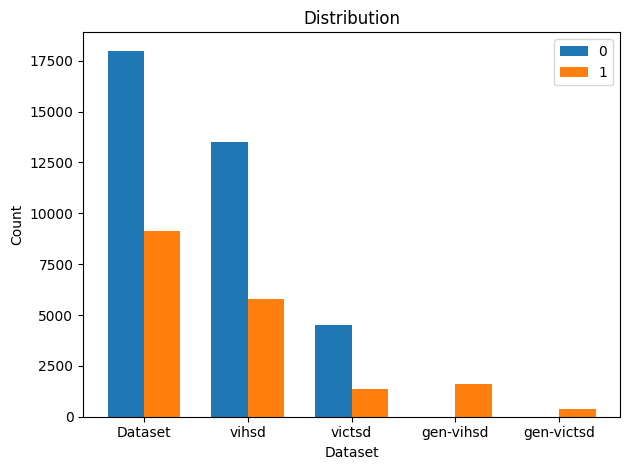

In [27]:
df = pd.read_csv("data/balanced.csv")

counts_df = df.groupby(["new_label", "origin"]).size().unstack(fill_value=0)
counts_df["Dataset"] = df.groupby("new_label").size()
counts_df = counts_df[["Dataset", "vihsd", "victsd", "gen-vihsd", "gen-victsd"]]

groups = ["Dataset", "vihsd", "victsd", "gen-vihsd", "gen-victsd"]
counts = [counts_df.loc[0, groups], counts_df.loc[1, groups]]

rate = counts[1] / counts[0]
print("Ratio:")
print(rate)

x = range(len(groups))
bar_width = 0.35

plt.bar(x, counts[0], width=bar_width, label="0")
plt.bar([i + bar_width for i in x], counts[1], width=bar_width, label="1")

plt.xlabel("Dataset")
plt.ylabel("Count")
plt.title("Distribution")
plt.xticks([i + bar_width / 2 for i in x], groups)
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from utils.preprocess import preprocess_text

print(torch.__version__)

# Cấu hình
MODEL_NAME = "vinai/phobert-base-v2"
MODEL_PATH = "models/best_phobert_aug.pt"
BATCH_SIZE = 4
MAX_LEN = 256

# Thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model & tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)
model.eval()

# Dataset
class SentimentDataset(Dataset):
    def __init__(self, df):
        self.texts = [preprocess_text(t) for t in df['text']]
        self.labels = df['new_label'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Load test.csv
df = pd.read_csv("data/aug/test.csv").dropna(subset=["text", "new_label"])
test_dataset = SentimentDataset(df)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Dự đoán
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

# In kết quả
print(classification_report(all_labels, all_preds, digits=4))

2.5.1+cu118


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ASUS\AppData\Local\Temp\ipykernel_50332\2471809842.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via thi

              precision    recall  f1-score   support

           0     0.8232    0.8228    0.8230      3600
           1     0.6512    0.6519    0.6515      1827

    accuracy                         0.7652      5427
   macro avg     0.7372    0.7373    0.7373      5427
weighted avg     0.7653    0.7652    0.7653      5427



In [29]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Để hiển thị tiến độ trong quá trình huấn luyện
import joblib  # Để lưu và tải mô hình

# Đọc dữ liệu
train_df = pd.read_csv("data/aug/train.csv")
val_df = pd.read_csv("data/aug/val.csv")
test_df = pd.read_csv("data/aug/test.csv")

# Áp dụng tiền xử lý cho dữ liệu và theo dõi tiến độ
tqdm.pandas(desc="Applying preprocess_text to Train data")
train_df['text'] = train_df['text'].progress_apply(lambda x: preprocess_text(x))  # Áp dụng tiền xử lý cho dữ liệu train

tqdm.pandas(desc="Applying preprocess_text to Validation data")
val_df['text'] = val_df['text'].progress_apply(lambda x: preprocess_text(x))      # Áp dụng tiền xử lý cho dữ liệu validation

tqdm.pandas(desc="Applying preprocess_text to Test data")
test_df['text'] = test_df['text'].progress_apply(lambda x: preprocess_text(x))    # Áp dụng tiền xử lý cho dữ liệu test

# Chia dữ liệu train và validation
X_train = train_df['text']
y_train = train_df['new_label']
X_val = val_df['text']
y_val = val_df['new_label']
X_test = test_df['text']
y_test = test_df['new_label']

# Biến đổi văn bản thành vector sử dụng TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Tạo vector từ 1-gram và 2-gram

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Khởi tạo mô hình SVM
svm_model = SVC(kernel='linear', class_weight='balanced')  # class_weight='balanced' giúp cân bằng giữa các lớp

# Huấn luyện mô hình SVM và hiển thị tiến độ
print("Training model...\n")
for epoch in tqdm(range(5), desc="Training Epochs", unit="epoch"):
    svm_model.fit(X_train_tfidf, y_train)

    # Dự đoán trên tập validation
    val_preds = svm_model.predict(X_val_tfidf)
    val_f1 = f1_score(y_val, val_preds, average='macro')
    print(f"Epoch {epoch + 1} - Validation F1 Score: {val_f1:.4f}")

# Lưu mô hình sau khi huấn luyện
model_filename = "models/svm_model.pkl"
joblib.dump(svm_model, model_filename)
print(f"Model saved to {model_filename}")

# Dự đoán trên tập test
test_preds = svm_model.predict(X_test_tfidf)

# Đánh giá kết quả
print("\nTest Classification Report:")
print(classification_report(y_test, test_preds, digits=4))

Applying preprocess_text to Test data: 100%|██████████| 5427/5427 [00:09<00:00, 552.42it/s]


Training model...



Training Epochs:  20%|██        | 1/5 [00:23<01:32, 23.03s/epoch]

Epoch 1 - Validation F1 Score: 0.7714


Training Epochs:  40%|████      | 2/5 [00:44<01:06, 22.17s/epoch]

Epoch 2 - Validation F1 Score: 0.7714


Training Epochs:  60%|██████    | 3/5 [01:05<00:43, 21.56s/epoch]

Epoch 3 - Validation F1 Score: 0.7714


Training Epochs:  80%|████████  | 4/5 [01:26<00:21, 21.40s/epoch]

Epoch 4 - Validation F1 Score: 0.7714


Training Epochs: 100%|██████████| 5/5 [01:47<00:00, 21.48s/epoch]

Epoch 5 - Validation F1 Score: 0.7714
Model saved to models/svm_model.pkl



Test Classification Report:
              precision    recall  f1-score   support

           0     0.8607    0.8117    0.8355      3600
           1     0.6663    0.7411    0.7017      1827

    accuracy                         0.7879      5427
   macro avg     0.7635    0.7764    0.7686      5427
weighted avg     0.7953    0.7879    0.7904      5427



In [30]:
from nb import train, test

train_df = pd.read_csv("data/aug/train.csv")
test_df = pd.read_csv("data/aug/test.csv")

# Huấn luyện mô hình
model, vectorizer = train(train_df)

# Dự đoán trên tập kiểm tra
preds, labels = test(model, vectorizer, test_df)

              precision    recall  f1-score   support

           0     0.8258    0.8822    0.8531      3600
           1     0.7318    0.6333    0.6790      1827

    accuracy                         0.7984      5427
   macro avg     0.7788    0.7578    0.7660      5427
weighted avg     0.7942    0.7984    0.7945      5427

